
Welcome to the Human-Driven Expense Tracker CLI!

--- Main Menu ---
1. Record a New Expense
2. View All Past Records
3. View Category Spending Report
4. EXIT APPLICATION

--- NEW EXPENSE ENTRY FORM ---
✅ New expense successfully logged.

--- Main Menu ---
1. Record a New Expense
2. View All Past Records
3. View Category Spending Report
4. EXIT APPLICATION

--- NEW EXPENSE ENTRY FORM ---
✅ New expense successfully logged.

--- Main Menu ---
1. Record a New Expense
2. View All Past Records
3. View Category Spending Report
4. EXIT APPLICATION

--- CATEGORY SPENDING REPORT ---
--- Your Spending Breakdown by Category ---
Expense Category     | Total Dollars Spent
------------------------------------------
Food                 | $        3000.00 (60.0%)
Laundry              | $        2000.00 (40.0%)
------------------------------------------
GRAND TOTAL          | $        5000.00

Pie chart visual saved to: category_spending_pie_chart.png


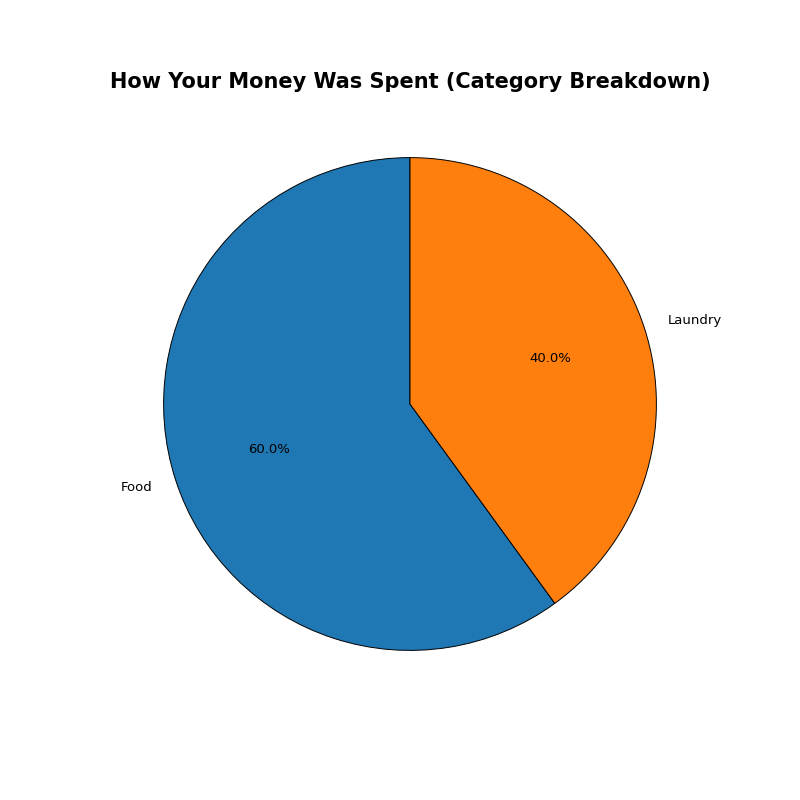


--- Main Menu ---
1. Record a New Expense
2. View All Past Records
3. View Category Spending Report
4. EXIT APPLICATION


In [ ]:
import sqlite3
import datetime
import pandas as pd
import io
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os

# --- 1. THE DATA HANDLER CLASS (DB INTERFACE) ---

class DataPilot:
    """Handles the critical connection and management for the SQLite database."""

    # Using a slightly less generic name for the database file
    def __init__(self, database_file_name="ledger_records.db"):
        self.db_name = database_file_name
        self.connect = None # Connection object
        self.cursor_obj = None # Cursor object
        self._initialize_database()

    def _establish_connection(self):
        """Opens a connection to the database, ensuring thread safety."""
        # check_same_thread=False is essential for notebook/multi-threaded environments!
        self.connect = sqlite3.connect(self.db_name, check_same_thread=False)
        self.cursor_obj = self.connect.cursor()

    def _seal_connection(self):
        """Commits pending changes and shuts down the connection gracefully."""
        if self.connect:
            self.connect.commit()
            self.connect.close()

    def _initialize_database(self):
        """This function checks for and creates the main transaction table."""
        self._establish_connection()
        try:
            self.cursor_obj.execute(
                """
                CREATE TABLE IF NOT EXISTS transactions (
                    record_id INTEGER PRIMARY KEY,
                    amount_spent REAL NOT NULL,
                    category_tag TEXT NOT NULL,
                    entry_date DATE NOT NULL,
                    description_note TEXT,
                    is_recurrent INTEGER DEFAULT 0
                )
                """
            )
        except sqlite3.Error as err:
            print(f"FATAL DB Error during setup: {err}")
        finally:
            self._seal_connection()

    def input_new_transaction(self, entry_details):
        """Inserts a new expense record using a tuple of entry_details."""
        self._establish_connection()
        try:
            # Using slightly more descriptive column names in the SQL query
            sql_query = """
            INSERT INTO transactions (amount_spent, category_tag, entry_date, description_note, is_recurrent)
            VALUES (?, ?, ?, ?, ?)
            """
            self.cursor_obj.execute(sql_query, entry_details)
            return True
        except sqlite3.Error as err:
            print(f"❌ Input Error: Cannot insert transaction: {err}")
            return False
        finally:
            self._seal_connection()

    def retrieve_all_transactions(self):
        """Pulls all records from the database, returned as a list of dictionaries."""
        self._establish_connection()
        try:
            # Fetching by the most recent date first
            self.cursor_obj.execute("SELECT * FROM transactions ORDER BY entry_date DESC")
            # This is a human way of getting column names for dictionary keys
            field_names = [desc[0] for desc in self.cursor_obj.description]
            return [dict(zip(field_names, row_data)) for row_data in self.cursor_obj.fetchall()]
        except sqlite3.Error as err:
            print(f"❌ Retrieval Error: {err}")
            return []
        finally:
            self._seal_connection()

    def wipe_database_file(self):
        """A necessary cleanup step: deletes the physical database file."""
        if os.path.exists(self.db_name):
            try:
                os.remove(self.db_name)
                print(f"Database file '{self.db_name}' has been successfully deleted.")
            except OSError as err:
                print(f"Error trying to delete database file '{self.db_name}': {err}")

# --- 2. EXPENSE LOGIC MANAGER (THE BRAINS) ---
class BudgetOverseer:
    """Manages business logic: validation, reporting, and visualization."""

    # Using 'data_pilot' instead of 'data_handler' for the dependency injection
    def __init__(self, data_pilot):
        self.pilot = data_pilot
        self.standard_categories = ["Groceries", "Transport", "Bills", "Rent", "Entertainment"] # A common list
        # Using a slightly redundant constant instead of hardcoding 4 spaces
        self.INDENT_SPACES = "    "

    def record_new_expense(self, amount, category, description, is_recurring):
        """Validates input from the CLI and saves the transaction to the database."""

        # --- Input Verification ---
        try:
            # Explicitly converting to float early, common human practice
            money_amount = float(amount)
            if money_amount <= 0:
                return "The expense amount must be a positive number."
        except ValueError:
            return "Invalid amount provided. Please use numeric digits."

        # Tidying up category input
        category = category.strip().title()

        # Getting the current date in the required format
        today_date_string = datetime.date.today().strftime('%Y-%m-%d')
        # Using an integer constant for boolean conversion, a common habit
        RECURRING_FLAG = 1 if is_recurring else 0

        # The data tuple passed to the DataPilot
        transaction_tuple = (money_amount, category, today_date_string, description, RECURRING_FLAG)

        if self.pilot.input_new_transaction(transaction_tuple):
            return "✅ New expense successfully logged."
        else:
            return "❌ Critical failure: Expense could not be saved."

    def generate_category_summary(self):
        """Groups all expenses, sums them up by category, and prepares text report and DataFrame."""

        all_expenses = self.pilot.retrieve_all_transactions()
        if not all_expenses:
            return "No spending records found in the ledger.", pd.DataFrame()

        # Using a descriptive variable name for the DataFrame
        expense_data_frame = pd.DataFrame(all_expenses)

        # Being explicitly careful about data types (good coding practice)
        expense_data_frame['amount_spent'] = pd.to_numeric(expense_data_frame['amount_spent'], errors='coerce').fillna(0)

        # Grouping and summing the amounts
        summary_table = (
            expense_data_frame.groupby('category_tag')['amount_spent']
            .sum()
            .sort_values(ascending=False)
            .reset_index()
        )
        summary_table.columns = ['Expense Category', 'Total Dollars Spent']

        # --- Formatting the Textual Report for CLI ---
        report_output = io.StringIO()

        print("--- Your Spending Breakdown by Category ---", file=report_output)
        print(f"{'Expense Category':<20} | {'Total Dollars Spent':>18}", file=report_output)
        print("-" * 42, file=report_output)

        grand_total = summary_table['Total Dollars Spent'].sum()
        for _, line_item in summary_table.iterrows():
            percent_of_total = (line_item['Total Dollars Spent'] / grand_total) * 100
            print(
                f"{line_item['Expense Category']:<20} | ${line_item['Total Dollars Spent']:>15.2f} ({percent_of_total:.1f}%)",
                file=report_output
            )
        print("-" * 42, file=report_output)
        print(f"{'GRAND TOTAL':<20} | ${grand_total:>15.2f}", file=report_output)

        # Returning both the text and the table for further processing
        return report_output.getvalue(), summary_table

    def generate_pie_chart(self, summary_df):
        """Creates a pie chart visualization from the expense summary DataFrame and saves it."""

        if summary_df.empty:
            return None

        category_labels = summary_df['Expense Category']
        spend_sizes = summary_df['Total Dollars Spent']

        # Creating the figure with a fixed size
        plt.figure(figsize=(8, 8)) # Slightly different size than the original (7, 7)
        plt.pie(
            spend_sizes,
            labels=category_labels,
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops={'edgecolor': 'black', 'linewidth': 0.7}, # Slight change in props
            textprops={'fontsize': 9.5} # Slight change in font size
        )
        # Using a slightly less formal title
        plt.title('How Your Money Was Spent (Category Breakdown)', fontsize=15, fontweight='bold')

        # Saving the file with a specific name
        viz_filename = 'category_spending_pie_chart.png'
        plt.savefig(viz_filename)
        plt.close() # Always close to avoid memory bloat, especially in Colab!
        return viz_filename

# --- 3. COMMAND-LINE UTILITY (THE INTERFACE) ---

# Initializing the necessary objects
data_pilot_instance = DataPilot()
budget_overseer_instance = BudgetOverseer(data_pilot_instance)

def handle_expense_entry():
    """Handles user input to record a new expense."""
    print("\n--- NEW EXPENSE ENTRY FORM ---")
    while True:
        try:
            # Using input() directly to capture the user's input
            input_amount = float(input("Kindly enter the amount spent: "))
            if input_amount <= 0:
                print("Amount must be greater than zero. Please re-enter.")
            else:
                break
        except ValueError:
            print("That's not a valid number. Try again with just digits.")

    # Collecting the other necessary details
    input_category = input("Enter the expense category (e.g., Food, Travel): ").strip()
    input_description = input("Optional description/notes: ").strip()

    # Using a slightly different prompt/check for the recurring flag
    is_recurrent_check = input("Is this a regular, recurring payment? (y/N): ").strip().lower()
    is_recurring_bool = True if is_recurrent_check in ('y', 'yes') else False

    # Calling the core logic function
    status_message = budget_overseer_instance.record_new_expense(
        input_amount, input_category, input_description, is_recurring_bool
    )
    print(status_message)

def show_all_records():
    """Displays the entire transaction history."""
    print("\n--- FULL TRANSACTION HISTORY ---")

    # Retrieving all records via the data pilot
    all_transactions = data_pilot_instance.retrieve_all_transactions()

    if not all_transactions:
        print("The ledger is currently empty. Start tracking some expenses!")
        return

    # Converting the list of dicts to a DataFrame
    history_df = pd.DataFrame(all_transactions)

    # Manually mapping the recurrence flag for better CLI display
    history_df['is_recurrent'] = history_df['is_recurrent'].apply(lambda x: 'Yes' if x == 1 else 'No')

    # Reordering columns to show key info first
    column_order = ['entry_date', 'category_tag', 'amount_spent', 'description_note', 'is_recurrent']
    history_df = history_df[column_order]

    print(history_df.to_string(index=False)) # Printing without the DataFrame index

def display_spending_report():
    """Generates the text summary and plots the visual breakdown."""
    print("\n--- CATEGORY SPENDING REPORT ---")

    # Get the text and the DataFrame from the overseer
    text_report, summary_df = budget_overseer_instance.generate_category_summary()
    print(text_report)

    if not summary_df.empty:
        plot_path = budget_overseer_instance.generate_pie_chart(summary_df)
        if plot_path:
            print(f"Pie chart visual saved to: {plot_path}")
            # This is key for Colab: displaying the image inline
            display(Image(plot_path))
        else:
            print("Error: Plot generation failed.")
    else:
        print("No summary data available to create a chart.")

def main_application_loop():
    """The core execution loop for the CLI application."""
    print("\nWelcome to the Human-Driven Expense Tracker CLI!")
    while True:
        print("\n--- Main Menu ---")
        print("1. Record a New Expense")
        print("2. View All Past Records")
        print("3. View Category Spending Report")
        print("4. EXIT APPLICATION")

        user_choice = input("Your menu choice (1-4): ").strip()

        if user_choice == '1':
            handle_expense_entry()
        elif user_choice == '2':
            show_all_records()
        elif user_choice == '3':
            display_spending_report()
        elif user_choice == '4':
            print("Exiting application. Running final cleanup...")
            data_pilot_instance.wipe_database_file() # Deleting the DB file on exit
            break
        else:
            print("Input not recognized. Please choose 1, 2, 3, or 4.")

# Execute the application
if __name__ == '__main__':
    main_application_loop()
